In [12]:
#| code-fold: true
#!pip install -Uqq fastbook
#!pip install fastai
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In chapter 4 of the book, we start to really get into what's going on under the hood with deep learning. Turns out, tensors are a pretty important piece. We are still in the realm of computer vision, and we are going to work on distinguishing between handwritten digits.

First we use the `untar_data` function to grab a sample of data from the famous MNIST data set. This function returns the path where that data was stored locally.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

In [4]:
path

Path('.')

Now we want to briefly inspect the contents of one of our training data folders. This is for the number 7. You can see that it's just a series of .png image files.

In [5]:
threes_dir = (path/'train/3').ls().sorted()
sevens_dir = (path/'train/7').ls().sorted()
sevens_dir

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

In order to look at a single image, we can just open it using `Image.open` which comes from the Python Image Library (PIL).

In [6]:
im3_path = threes_dir[1]
im3 = Image.open(im3_path)
im3

Jupyter knows how to display various files, so we can see that image above. But what exactly is an image made up of? If we turn that image into an array, or to a tensor (the next two cells), slicing them so you aren't just seeing zeros on the edges, then you can see that these images are made up of a matrix of values from 0 to 255.

In [7]:
im3_arr = array(im3)[4:10, 4:10]
im3_arr

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [8]:
im3_tns = tensor(im3)[4:10, 4:10]
im3_tns

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can use the `show_image` function to turn those 0-255 values back into an image, like so:

<AxesSubplot:>

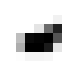

In [9]:
show_image(im3_arr)

A really nice way of visualising exactly what is going on is to turn this image into a pandas dataframe and then for every individual pixel value, use that value as the background gradient for that cell. Here's an example of part of an image of a handwritten number 3.

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


So now we have a toolkit of ways to view the pixel values that make up an image. We also have a mental model for how we can think about images and how computers represent those images stored on our machine.

But how might we then best go about knowing whether a particular image is a 3, let's say, or a 7?

One naive approach might be just to get the average value for each individual pixel for all of the threes in our training data, and then just compare the difference between our sample image and this average representation.

Let's try that now.

## Getting the average values for our images

We'll set up two lists with images of the digits converted to tensors. You can see that we have 6131 images in our 'threes' list.

In [14]:
threes_tensors = [tensor(Image.open(i)) for i in threes_dir]
sevens_tensors = [tensor(Image.open(i)) for i in sevens_dir]
len(threes_tensors)

6131

We can view an individual image, as before, with the `show_image` function:

<AxesSubplot:>

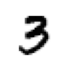

In [15]:
show_image(threes_tensors[3])

Now in order to get the average values for each pixels, we can use the `stack` method to handle the first part of this.

Think of it as basically adding an extra dimension to your data structure, such that you have a 'stack' (it's a useful mental image) of those images.

In [16]:
threes_stack = torch.stack(threes_tensors)

If we look at the `shape` of our Pytorch stack now, we can see we have our 28x28 image, but we have a stack of 6131 of them.

In [17]:
threes_stack.shape

torch.Size([6131, 28, 28])

Each individual image is still a tensor:

In [18]:
a_three = threes_stack[3][4:16, 4:16]
a_three

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 104, 253, 253, 253, 255, 253],
        [  0,   0,   0,   0,   0, 178, 248, 252, 252, 252, 253, 252],
        [  0,   0,   0,   0,   0, 186, 252, 252, 252, 252, 253, 252],
        [  0,   0,   0,   0,   0, 186, 252, 243, 172, 172,  39,  39],
        [  0,   0,   0,   0,   0,  39,  53,  47,   0,   0,   0,  29],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  54, 208],
        [  0,   0,   0,   0,   0,   0,   0,   0,   3,  41, 253, 252],
        [  0,   0,   0,   0,   0,   0,   5,  41, 165, 252, 253, 252],
        [  0,   0,   0,   0,   0, 109, 163, 252, 252, 252, 253, 252],
        [  0,   0,   0,   0,   0, 186, 252, 252, 252, 252, 253, 252],
        [  0,   0,   0,   0,   0, 187, 253, 253, 253, 253, 134,  77]], dtype=torch.uint8)

Generally speaking, for some operations (like getting the mean average) we're going to want to convert the values to floats, and it also makes sense to normalise the values at the same time. Instead of having a range of 0-255, we want a range of 0-1.

In [19]:
threes_stack[3][4:16, 4:16].float()/255

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4078, 0.9922, 0.9922, 0.9922, 1.0000, 0.9922],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6980, 0.9725, 0.9882, 0.9882, 0.9882, 0.9922, 0.9882],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7294, 0.9882, 0.9882, 0.9882, 0.9882, 0.9922, 0.9882],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7294, 0.9882, 0.9529, 0.6745, 0.6745, 0.1529, 0.1529],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1529, 0.2078, 0.1843, 0.0000, 0.0000, 0.0000, 0.1137],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2118, 0.8157],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.1608, 0.9922, 0.9882],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.1608, 0.6471, 0.9882, 0.9922, 0.9882],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.000

Now that we've done it for a single image, we can perform the same operations on our whole Pytorch stack.

In [20]:
threes_stack = torch.stack(threes_tensors).float()/255
sevens_stack = torch.stack(sevens_tensors).float()/255
threes_stack.shape # it's good to keep in touch with the shape of our stack

torch.Size([6131, 28, 28])

Now we're getting closer to our desired result. We can squash the stack down into just two dimensions with a simple call to `.mean(0)`, where `0` is the index value of the dimension through which we want to calculate the mean. You'll see now that the `shape` property of our `threes_means` variable is simply a 28x28 image.

In [21]:
threes_means = threes_stack.mean(0)
threes_means.shape

torch.Size([28, 28])

When we show that image, you'll see that it's a sort of blurry 'ideal' version of a three

<AxesSubplot:>

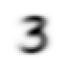

In [22]:
show_image(threes_means)

We can do the same for the sevens:

<AxesSubplot:>

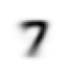

In [23]:
sevens_means = sevens_stack.mean(0)
show_image(sevens_means)

## Validation: Comparing our average three with a specific three

Now we have our average values, we want to compare these with a single specific digit image. We'll get the difference between those values and whichever difference is the smallest will most likely be the best answer.

Our averaged three is still `threes_means` and we can get a single three from our validation set like this:

<AxesSubplot:>

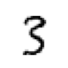

In [42]:
threes_dir_validation = (path/'valid/3').ls().sorted()
sevens_dir_validation = (path/'valid/7').ls().sorted()

im3_validation_path = threes_dir_validation[5]
im3_validation = tensor(Image.open(im3_validation_path)).float()/255

im7_validation_path = sevens_dir_validation[3]
im7_validation = tensor(Image.open(im7_validation_path)).float()/255

show_image(im3_validation)

<AxesSubplot:>

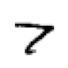

In [43]:
show_image(im7_validation)

:::{.callout-note}

Calculating the difference between two objects

:::

We can use two different measurements of the difference between our mean value and the individual image:

- mean absolute difference (calculated by taking the mean of the absolute difference between the two tensor values). Also known as the L1 Norm.
- root mean squared error (calculated by first squaring the difference between the two tensor values, taking the mean and then square rooting those values). Also known as the L2 Norm.

The second option, the RMSE, gives a stronger signal, you might say, for the differences because you are taking the averages from the squared values. Squaring the difference also takes care of any negative values you might have.

In [48]:
mean_absolute_difference_3 = (im3_validation - threes_means).abs().mean()
root_mean_squared_error_3 = ((im3_validation - threes_means)**2).mean().sqrt()
mean_absolute_difference_3, root_mean_squared_error_3

(tensor(0.1188), tensor(0.2160))

In [49]:
mean_absolute_difference_7 = (im7_validation - threes_means).abs().mean()
root_mean_squared_error_7 = ((im7_validation - threes_means)**2).mean().sqrt()
mean_absolute_difference_7, root_mean_squared_error_7

(tensor(0.1702), tensor(0.3053))

We can now see that our individual three image is indeed closer to the `threes_means` composite image than to the `sevens_means` composite image. A smaller value at this point is what we're looking for, and the threes have it.

It turns out that there is another way to calculate the difference that's built in to Pytorch as loss functions:

In [50]:
F.l1_loss(im3_validation, threes_means), F.mse_loss(im3_validation, threes_means).sqrt()

(tensor(0.1188), tensor(0.2160))

It's a bit more concise, though it does obscure what's going on under the hood in terms of calculations.

## Results of the naive approach

So this tells us that our single three is closer to an ideal 3 than an ideal 7, which is great since it reflects the ground truth of our problem. But can we get a metric to know how well we perform on average against a large number of threes and sevens from our validation set?

Yes, since we have that dataset ready for use!

In [52]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Now we can write a helper function that will allow us to calculate the distance between two images. We use the RMSE or L1 Norm for this difference calculation:

In [57]:
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))

We can use this function on our previous example:

In [60]:
mnist_distance(im3_validation, threes_means)

tensor(0.1188)

We can continue onwards by comparing the rank 3 tensor with the rank 2 tensor. This brings a concept called 'broadcasting' into play.

We are comparing a tensor with 2 dimensions with a tensor with 3 dimensions, so Pytorch behaves as if both tensors have three dimensions, and (without taking extra memory) pretends as if there are multiple copies of the image in 2 dimensions. This effectively makes it as if we're comparing two 3-dimensional tensors.

From this next calculation, we see returned back a collection of the distances between all of the validation images.

In [62]:
mnist_distance(valid_3_tens, threes_means)

tensor([0.1328, 0.1523, 0.1245,  ..., 0.1383, 0.1280, 0.1138])

In order to check whether an image is a 3, we basically need to know whether the difference for the number 3 is larger than the difference for the number 7.

We can write a helper function for that:

In [63]:
def is_3(img):
    return mnist_distance(img, threes_means) < mnist_distance(img, sevens_means)

We can now check our ground truth examples:

In [66]:
is_3(im3_validation), is_3(im7_validation)

(tensor(True), tensor(False))

That's what we expected to happen. Our 3 image is a 3, and our 7 image is not a 3.

If we want to check the distance in general for our validation set, we have to convert them into floats and then get the mean, but it's really easy. Again, this uses broadcasting:

In [69]:
validation_accuracy_3 = is_3(valid_3_tens).float().mean()
validation_accuracy_7 = 1 - is_3(valid_7_tens).float().mean()
validation_accuracy_3, validation_accuracy_7

(tensor(0.9168), tensor(0.9854))

Overall, then, we can calculate how good our toy or baseline model is for the entire problem:

In [71]:
(validation_accuracy_3 + validation_accuracy_7) / 2

tensor(0.9511)

Pretty good!

This was of course just a naive way to solve the problem. There are more advanced techniques which we'll tackle next.